In [60]:
import pandas as pd

PATH_2012 = "resourcetradeearth-all-all-243-2012.xlsx"
PATH_2022 = "resourcetradeearth-all-all-243-2022.xlsx"

RICE_RESOURCE = "Rice, semi-milled or wholly milled"
VALUE_COL = "Value (1000USD)"
WEIGHT_COL = "Weight (1000kg)"

def load_rice_flows(path: str) -> pd.DataFrame:
    df = pd.read_excel(
        path,
        sheet_name="Trades",
        usecols=["Exporter ISO3", "Exporter", "Importer ISO3", "Importer",
                 "Resource", "Year", VALUE_COL, WEIGHT_COL],
    )

    # Keep only rice rows
    df = df[df["Resource"] == RICE_RESOURCE].copy()

    # Aggregate to one row per exporter-importer pair
    agg = (
        df.groupby(["Exporter ISO3", "Importer ISO3", "Exporter", "Importer"], as_index=False)[[VALUE_COL, WEIGHT_COL]]
          .sum(min_count=1)
    )

    # Replace missing with 0 for convenience (optional)
    agg[[VALUE_COL, WEIGHT_COL]] = agg[[VALUE_COL, WEIGHT_COL]].fillna(0.0)
    return agg

flows_2012 = load_rice_flows(PATH_2012)
flows_2022 = load_rice_flows(PATH_2022)

print(flows_2012.shape, flows_2022.shape)


(5729, 6) (6537, 6)


In [61]:
import networkx as nx

def build_trade_graph(flows: pd.DataFrame, weight_col: str) -> nx.DiGraph:
    G = nx.DiGraph()

    for _, r in flows.iterrows():
        u = r["Exporter ISO3"]
        v = r["Importer ISO3"]
        w = float(r[weight_col])

        if w <= 0:
            continue

        # keep readable labels on nodes
        G.add_node(u, label=r["Exporter"])
        G.add_node(v, label=r["Importer"])

        # store both value and weight on the edge for later use
        G.add_edge(
            u, v,
            weight=w,
            value=float(r[VALUE_COL]),
            qty=float(r[WEIGHT_COL]),
        )

    return G

G12_value = build_trade_graph(flows_2012, VALUE_COL)
G22_value = build_trade_graph(flows_2022, VALUE_COL)

G12_qty = build_trade_graph(flows_2012, WEIGHT_COL)
G22_qty = build_trade_graph(flows_2022, WEIGHT_COL)


In [62]:
import numpy as np

def scorecard(G: nx.DiGraph) -> dict:
    nodes = G.number_of_nodes()
    edges = G.number_of_edges()
    total_weight = sum(d["weight"] for _, _, d in G.edges(data=True))
    density = nx.density(G)
    reciprocity = nx.reciprocity(G)  # can be None if not defined

    out_strength = dict(G.out_degree(weight="weight"))
    in_strength  = dict(G.in_degree(weight="weight"))

    # undirected clustering (often used as a “triadic closure” proxy)
    UG = nx.Graph()
    for u, v, d in G.edges(data=True):
        w = d.get("weight", 1.0)
        if UG.has_edge(u, v):
            UG[u][v]["weight"] += w
        else:
            UG.add_edge(u, v, weight=w)
    avg_clust = nx.average_clustering(UG) if UG.number_of_nodes() > 2 else np.nan

    return {
        "nodes": nodes,
        "edges": edges,
        "total_weight": total_weight,
        "density": density,
        "reciprocity": reciprocity,
        "avg_clustering_undirected": avg_clust,
        "out_strength": out_strength,
        "in_strength": in_strength,
    }

s12 = scorecard(G12_value)
s22 = scorecard(G22_value)

print({k: s12[k] for k in ["nodes","edges","total_weight","density","reciprocity","avg_clustering_undirected"]})
print({k: s22[k] for k in ["nodes","edges","total_weight","density","reciprocity","avg_clustering_undirected"]})


{'nodes': 227, 'edges': 5614, 'total_weight': 90654397.49378186, 'density': 0.10943043156212233, 'reciprocity': 0.363021018881368, 'avg_clustering_undirected': 0.6783319552701652}
{'nodes': 227, 'edges': 6360, 'total_weight': 108366321.0941174, 'density': 0.12397177497953296, 'reciprocity': 0.40220125786163524, 'avg_clustering_undirected': 0.6950804352909561}


In [63]:
def top_k_strength(strength_dict: dict, k=10) -> pd.DataFrame:
    s = pd.Series(strength_dict).sort_values(ascending=False).head(k)
    return s.rename("strength").reset_index().rename(columns={"index":"ISO3"})

top_export_2012 = top_k_strength(s12["out_strength"], 10)
top_export_2022 = top_k_strength(s22["out_strength"], 10)
top_import_2012 = top_k_strength(s12["in_strength"], 10)
top_import_2022 = top_k_strength(s22["in_strength"], 10)

print(top_export_2012)
print(top_export_2022)


  ISO3      strength
0  THA  2.386124e+07
1  IND  1.704211e+07
2  VNM  1.398476e+07
3  PAK  9.425466e+06
4  USA  6.749677e+06
5  ITA  2.787720e+06
6  BRA  1.813724e+06
7  URY  1.789505e+06
8  CHN  1.732921e+06
9  ARE  1.706935e+06
  ISO3      strength
0  IND  3.804159e+07
1  THA  1.891474e+07
2  VNM  1.184167e+07
3  PAK  8.645676e+06
4  USA  5.943953e+06
5  CHN  3.920611e+06
6  ITA  2.943942e+06
7  KHM  2.204123e+06
8  MMR  1.623680e+06
9  URY  1.440377e+06


In [64]:
def edge_changes(flows12: pd.DataFrame, flows22: pd.DataFrame, weight_col: str) -> pd.DataFrame:
    e12 = flows12.groupby(["Exporter ISO3", "Importer ISO3"], as_index=False)[weight_col].sum().rename(columns={weight_col:"w_2012"})
    e22 = flows22.groupby(["Exporter ISO3", "Importer ISO3"], as_index=False)[weight_col].sum().rename(columns={weight_col:"w_2022"})

    m = e12.merge(e22, on=["Exporter ISO3","Importer ISO3"], how="outer")
    m[["w_2012","w_2022"]] = m[["w_2012","w_2022"]].fillna(0.0)
    m["delta"] = m["w_2022"] - m["w_2012"]
    return m

delta_edges = edge_changes(flows_2012, flows_2022, VALUE_COL)

new_edges  = ((delta_edges["w_2012"] == 0) & (delta_edges["w_2022"] > 0)).sum()
lost_edges = ((delta_edges["w_2012"] > 0) & (delta_edges["w_2022"] == 0)).sum()

print("New edges:", new_edges, "Lost edges:", lost_edges)

top_increases = delta_edges.sort_values("delta", ascending=False).head(15)
top_decreases = delta_edges.sort_values("delta", ascending=True).head(15)

print(top_increases)
print(top_decreases)


New edges: 2268 Lost edges: 1522
     Exporter ISO3 Importer ISO3        w_2012        w_2022         delta
3232           IND           IRN  2.325804e+06  4.985161e+06  2.659356e+06
3233           IND           IRQ  3.792984e+05  2.354084e+06  1.974786e+06
3159           IND           BEN  1.506029e+05  1.500913e+06  1.350311e+06
6992           THA           USA  2.027223e+06  3.158826e+06  1.131603e+06
7833           VNM           GHA  1.436186e+05  1.215857e+06  1.072238e+06
3302           IND           SAU  3.824524e+06  4.883588e+06  1.059065e+06
3161           IND           BGD  4.988973e+05  1.503538e+06  1.004641e+06
3215           IND           GIN  9.508298e+04  1.036466e+06  9.413831e+05
3284           IND           NPL  1.358041e+05  1.058942e+06  9.231383e+05
7804           VNM           CHN  9.109849e+05  1.728089e+06  8.171044e+05
3181           IND           CIV  2.265558e+05  1.031625e+06  8.050687e+05
4007           KHM           CHN  4.618612e+03  8.073615e+05  8.027

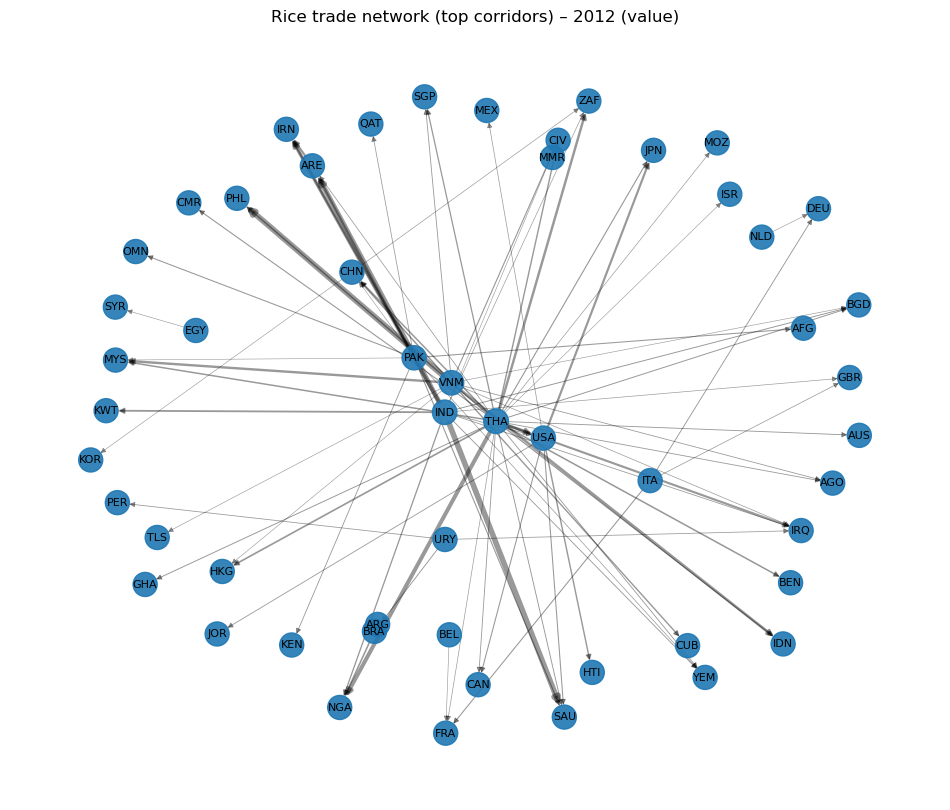

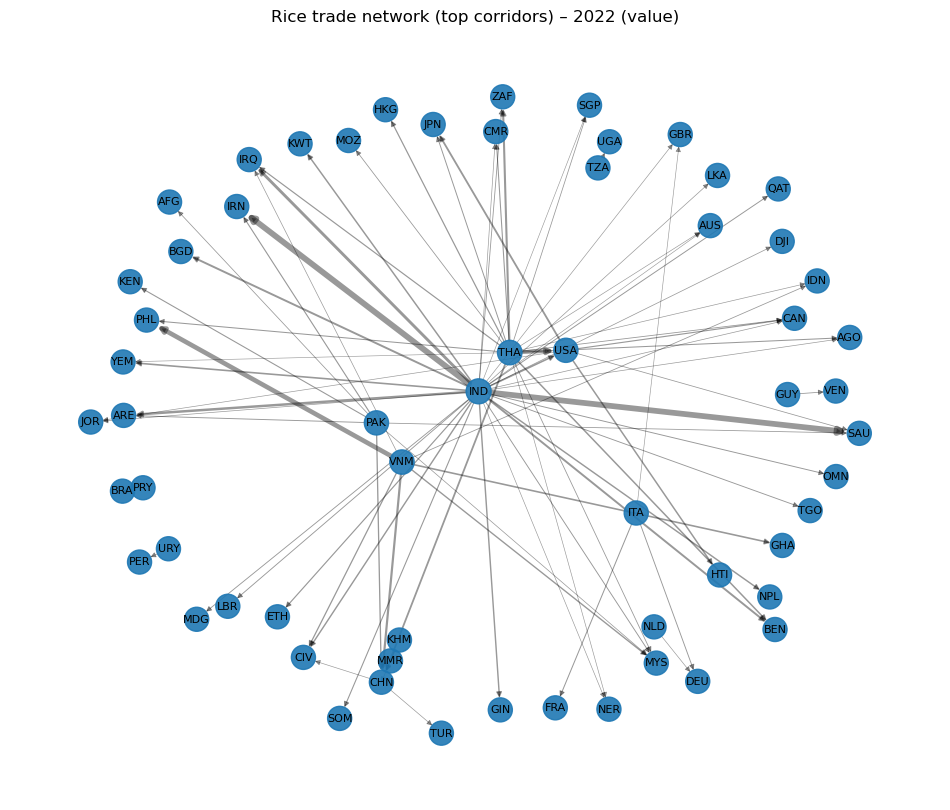

In [65]:
import matplotlib.pyplot as plt

def plot_top_edges(G: nx.DiGraph, n_edges=80, title=""):
    edges = sorted(G.edges(data=True), key=lambda x: x[2].get("weight", 0.0), reverse=True)[:n_edges]
    H = nx.DiGraph()
    H.add_edges_from([(u, v, d) for u, v, d in edges])

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(H, seed=7, k=0.9)

    node_sizes = [300 + 50*H.out_degree(n, weight="weight")/max(1, sum(d["weight"] for _,_,d in H.edges(data=True)))
                  for n in H.nodes()]
    edge_widths = [0.2 + 4.0*d["weight"]/max(1, max(dd["weight"] for _,_,dd in H.edges(data=True)))
                   for _,_,d in H.edges(data=True)]

    nx.draw_networkx_nodes(H, pos, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.4, arrowsize=8)
    nx.draw_networkx_labels(H, pos, font_size=8)

    plt.title(title)
    plt.axis("off")
    plt.show()

plot_top_edges(G12_value, n_edges=80, title="Rice trade network (top corridors) – 2012 (value)")
plot_top_edges(G22_value, n_edges=80, title="Rice trade network (top corridors) – 2022 (value)")


In [66]:
import pandas as pd
import networkx as nx

VALUE_COL = "Value (1000USD)"
RICE_RESOURCE = "Rice, semi-milled or wholly milled"

def load_rice_flows(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name="Trades")
    df = df[
        ["Exporter ISO3","Exporter","Importer ISO3","Importer",
         "Resource", "Year", VALUE_COL, "Weight (1000kg)"]
    ]
    df = df[df["Resource"] == RICE_RESOURCE].copy()

    # aggregate to exporter-importer pair
    df = (df.groupby(["Exporter ISO3","Importer ISO3","Exporter","Importer"], as_index=False)[[VALUE_COL]]
            .sum(min_count=1)
            .fillna(0.0))
    return df

def build_graph(flows: pd.DataFrame, weight_col: str = VALUE_COL) -> nx.DiGraph:
    G = nx.DiGraph()
    for _, r in flows.iterrows():
        u, v, w = r["Exporter ISO3"], r["Importer ISO3"], float(r[weight_col])
        if w <= 0:
            continue
        G.add_node(u, label=r["Exporter"])
        G.add_node(v, label=r["Importer"])
        G.add_edge(u, v, weight=w)

    # distance for weighted shortest paths / betweenness
    for u, v, d in G.edges(data=True):
        d["distance"] = 1.0 / d["weight"]
    return G

def centralities(G: nx.DiGraph) -> dict:
    return {
        # degree centrality in directed graphs can range up to 2.0 (in+out)
        "degree": nx.degree_centrality(G),
        "in_degree": nx.in_degree_centrality(G),
        "out_degree": nx.out_degree_centrality(G),

        # betweenness: unweighted vs weighted (via distance=1/weight)
        "betweenness": nx.betweenness_centrality(G, weight=None, normalized=True),
        "betweenness_weighted": nx.betweenness_centrality(G, weight="distance", normalized=True),
    }


In [ ]:
# --- Rice trade network centrality comparison: 2012 vs 2022 ---
# Requirements: pandas, networkx, openpyxl
# Optional (for faster betweenness on large graphs): python-igraph (not required)

import pandas as pd
import networkx as nx

PATH_2012 = "resourcetradeearth-all-all-243-2012.xlsx"
PATH_2022 = "resourcetradeearth-all-all-243-2022.xlsx"

SHEET = "Trades"
VALUE_COL = "Value (1000USD)"
QTY_COL   = "Weight (1000kg)"

# If your file uses a slightly different rice label, adjust this.
# This code falls back to a "contains 'Rice'" filter if exact match yields no rows.
RICE_RESOURCE_EXACT = "Rice, semi-milled or wholly milled"


def load_and_filter_rice(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=SHEET)

    needed = ["Exporter ISO3", "Exporter", "Importer ISO3", "Importer", "Resource", VALUE_COL, QTY_COL]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {path}: {missing}\nAvailable columns: {list(df.columns)}")

    # Filter to rice
    rice = df[df["Resource"] == RICE_RESOURCE_EXACT].copy()
    if rice.empty:
        # fallback: any resource containing "rice"
        rice = df[df["Resource"].astype(str).str.contains("rice", case=False, na=False)].copy()
        if rice.empty:
            raise ValueError("No rice rows found (exact match and fallback both empty). "
                             "Check the 'Resource' values in your file.")

    # Aggregate to exporter-importer pair
    rice = (
        rice.groupby(["Exporter ISO3", "Importer ISO3", "Exporter", "Importer"], as_index=False)[[VALUE_COL, QTY_COL]]
            .sum(min_count=1)
    )
    rice[[VALUE_COL, QTY_COL]] = rice[[VALUE_COL, QTY_COL]].fillna(0.0)
    return rice


def build_trade_graph(flows: pd.DataFrame, weight_col: str = VALUE_COL) -> nx.DiGraph:
    """
    Builds a directed graph where edges exporter->importer have:
      - weight: chosen weight_col (e.g., trade value)
      - distance: 1/weight (used for weighted shortest paths / weighted betweenness)
      - value, qty: stored for convenience
    """
    G = nx.DiGraph()

    for _, r in flows.iterrows():
        u = r["Exporter ISO3"]
        v = r["Importer ISO3"]
        w = float(r[weight_col])

        if w <= 0:
            continue

        G.add_node(u, label=r["Exporter"])
        G.add_node(v, label=r["Importer"])

        G.add_edge(
            u, v,
            weight=w,
            distance=1.0 / w,               # treat larger flows as "shorter" paths
            value=float(r[VALUE_COL]),
            qty=float(r[QTY_COL]),
        )

    return G


def compute_centralities(G: nx.DiGraph) -> pd.DataFrame:
    """
    Returns a DataFrame indexed by ISO3 with:
      - degree_centrality (total), in_degree_centrality, out_degree_centrality
      - betweenness (unweighted)
      - betweenness_weighted (weighted shortest paths using distance=1/weight)
      - strength_in/strength_out (weighted degrees using edge 'weight')
    """
    deg = nx.degree_centrality(G)
    indeg = nx.in_degree_centrality(G)
    outdeg = nx.out_degree_centrality(G)

    btw = nx.betweenness_centrality(G, weight=None, normalized=True)
    btw_w = nx.betweenness_centrality(G, weight="distance", normalized=True)

    strength_out = dict(G.out_degree(weight="weight"))
    strength_in = dict(G.in_degree(weight="weight"))

    # node labels for readability
    labels = {n: G.nodes[n].get("label", n) for n in G.nodes()}

    df = pd.DataFrame({
        "country": pd.Series(labels),
        "degree_centrality": pd.Series(deg),
        "in_degree_centrality": pd.Series(indeg),
        "out_degree_centrality": pd.Series(outdeg),
        "betweenness": pd.Series(btw),
        "betweenness_weighted": pd.Series(btw_w),
        "strength_out": pd.Series(strength_out),
        "strength_in": pd.Series(strength_in),
    })

    # Ensure numeric columns are numeric
    for c in ["degree_centrality", "in_degree_centrality", "out_degree_centrality",
              "betweenness", "betweenness_weighted", "strength_out", "strength_in"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

    df.index.name = "ISO3"
    return df


def top_n(df: pd.DataFrame, col: str, n: int = 10) -> pd.DataFrame:
    return df.sort_values(col, ascending=False).head(n)[["country", col]]


def compare_years(df12: pd.DataFrame, df22: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Produces a comparison table with:
      - score_2012, score_2022, delta
      - rank_2012, rank_2022, rank_delta (positive => improved rank)
    """
    a = df12[[col, "country"]].rename(columns={col: "score_2012"})
    b = df22[[col, "country"]].rename(columns={col: "score_2022"})
    merged = a.join(b[["score_2022"]], how="outer")

    merged["score_2012"] = merged["score_2012"].fillna(0.0)
    merged["score_2022"] = merged["score_2022"].fillna(0.0)
    merged["delta"] = merged["score_2022"] - merged["score_2012"]

    merged["rank_2012"] = merged["score_2012"].rank(ascending=False, method="min")
    merged["rank_2022"] = merged["score_2022"].rank(ascending=False, method="min")
    merged["rank_delta"] = merged["rank_2012"] - merged["rank_2022"]  # >0 means moved up

    # Keep the best available country name
    merged["country"] = merged["country"].fillna(df22["country"])

    # Sort by absolute change then by 2022 score
    merged = merged.sort_values(["delta", "score_2022"], ascending=[False, False])
    return merged


def spearman_corr(df: pd.DataFrame, col_a: str, col_b: str) -> float:
    # pandas Spearman uses rank correlation
    return float(df[[col_a, col_b]].corr(method="spearman").iloc[0, 1])


def main():
    # 1) Load rice flows
    flows12 = load_and_filter_rice(PATH_2012)
    flows22 = load_and_filter_rice(PATH_2022)

    # 2) Build graphs (value-weighted; change to QTY_COL if you want quantity-weighted)
    G12 = build_trade_graph(flows12, weight_col=VALUE_COL)
    G22 = build_trade_graph(flows22, weight_col=VALUE_COL)

    # 3) Compute centralities
    c12 = compute_centralities(G12)
    c22 = compute_centralities(G22)

    # 4) Print top 10 for a couple measures
    print("\nTop 10 (2012) degree_centrality:")
    print(top_n(c12, "degree_centrality", 10).to_string())

    print("\nTop 10 (2022) degree_centrality:")
    print(top_n(c22, "degree_centrality", 10).to_string())

    print("\nTop 10 (2012) betweenness_weighted:")
    print(top_n(c12, "betweenness_weighted", 10).to_string())

    print("\nTop 10 (2022) betweenness_weighted:")
    print(top_n(c22, "betweenness_weighted", 10).to_string())

    # 5) Compare years for chosen measures
    measures = ["degree_centrality", "in_degree_centrality", "out_degree_centrality",
                "betweenness", "betweenness_weighted"]

    comparisons = {}
    for m in measures:
        comparisons[m] = compare_years(c12, c22, m)

    print("\nBiggest risers by weighted betweenness (top 15 by rank_delta):")
    risers = comparisons["betweenness_weighted"].sort_values("rank_delta", ascending=False).head(15)
    print(risers[["country", "score_2012", "score_2022", "delta", "rank_2012", "rank_2022", "rank_delta"]].to_string())

    print("\nBiggest droppers by weighted betweenness (top 15 by rank_delta most negative):")
    droppers = comparisons["betweenness_weighted"].sort_values("rank_delta", ascending=True).head(15)
    print(droppers[["country", "score_2012", "score_2022", "delta", "rank_2012", "rank_2022", "rank_delta"]].to_string())

    # 6) Diagnostics: correlations (within-year) and stability (across years)
    # within-year correlation between out-degree and weighted betweenness
    # (align indexes first; fill missing with 0)
    merged12 = c12.copy()
    merged22 = c22.copy()

    print("\nSpearman(out_degree_centrality, betweenness_weighted):")
    print("2012:", spearman_corr(merged12, "out_degree_centrality", "betweenness_weighted"))
    print("2022:", spearman_corr(merged22, "out_degree_centrality", "betweenness_weighted"))

    # across-year stability: correlation of 2012 vs 2022 scores (aligned ISO3)
    aligned = c12.add_suffix("_2012").join(c22.add_suffix("_2022"), how="outer").fillna(0.0)

    def stability(col: str) -> float:
        return float(aligned[[f"{col}_2012", f"{col}_2022"]].corr(method="spearman").iloc[0, 1])

    print("\nStability across years (Spearman of scores 2012 vs 2022):")
    for m in ["out_degree_centrality", "in_degree_centrality", "degree_centrality", "betweenness_weighted"]:
        print(m + ":", stability(m))

    # 7) Export outputs if you want them
    c12.to_csv("rice_centralities_2012_value.csv")
    c22.to_csv("rice_centralities_2022_value.csv")
    for m, comp in comparisons.items():
        comp.to_csv(f"rice_centrality_compare_{m}_2012_vs_2022.csv")

    print("\nWrote CSVs:")
    print("- rice_centralities_2012_value.csv")
    print("- rice_centralities_2022_value.csv")
    print("- rice_centrality_compare_*_2012_vs_2022.csv")


if __name__ == "__main__":
    main()


Top 10 (2012) degree_centrality:
             country  degree_centrality
ISO3                                   
USA    United States           1.185841
THA         Thailand           1.101770
ITA            Italy           1.017699
CHN            China           0.964602
IND            India           0.960177
DEU          Germany           0.889381
PAK         Pakistan           0.876106
FRA           France           0.867257
GBR   United Kingdom           0.827434
VNM          Vietnam           0.796460

Top 10 (2022) degree_centrality:
             country  degree_centrality
ISO3                                   
USA    United States           1.252212
IND            India           1.101770
THA         Thailand           1.061947
FRA           France           1.017699
ITA            Italy           1.017699
TUR           Turkey           0.977876
DEU          Germany           0.942478
CHN            China           0.933628
NLD      Netherlands           0.929204
GBR   United